<a href="https://colab.research.google.com/github/SunGod1998/Summer_Internship_2020/blob/master/Index_Tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))   

Saving Price_All.csv to Price_All.csv
User uploaded file "Price_All.csv" with length 1527571 bytes


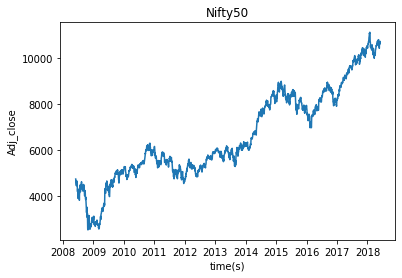

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf

df=pd.read_csv("Price_All.csv")
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
scaler=MinMaxScaler()

fig, ax = plt.subplots()
ax.plot(df["Date"], df["Price_51"])

ax.set(xlabel='time(s)', ylabel='Adj_close',
       title='Nifty50')
fig.savefig("benchmark.png")
plt.show()

In [102]:
#Implementing the seq2seq LSTM autoencoder and extract the top K stocks 
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, Dropout, SimpleRNN,GRU
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

df.head(3)
#X_AE=df.drop("Date",axis=1)
X_AE=df[df.columns[1:-1]]
scaled_X_AE=scaler.fit_transform(X_AE)
Data=scaled_X_AE
Data=np.reshape(Data,(1,Data.shape[0],Data.shape[1]))
model = Sequential()
model.add(SimpleRNN(100, activation='relu', input_shape=(Data.shape[1],Data.shape[2]),return_sequences=True,name='Enc_1'))
model.add(SimpleRNN(20, activation='relu', return_sequences=True,name='Enc_1_1'))
#model.add(SimpleRNN(Data.shape[2], activation='relu', return_sequences=True,name='Dec_1'))
model.add(TimeDistributed(Dense(Data.shape[2]),name='dec_1'))
model.compile(optimizer='rmsprop', loss='mse')

',patience=10,min_delta=0.01,'
hist=model.fit(Data,Data,epochs=200,batch_size=1,callbacks=[EarlyStopping(monitor='loss',patience=20,restore_best_weights=True)])

model=Model(inputs=model.inputs, outputs=model.layers[2].output)
decoded_data=model.predict(Data)
decoded_data.shape


Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3347
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 0.2228
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 0.2275
Epoch 4/200
1/1 [==============================] - 1s 1s/step - loss: 0.2113
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: 0.1948
Epoch 6/200
1/1 [==============================] - 1s 1s/step - loss: 0.1845
Epoch 7/200
1/1 [==============================] - 2s 2s/step - loss: 0.1767
Epoch 8/200
1/1 [==============================] - 1s 1s/step - loss: 0.1704
Epoch 9/200
1/1 [==============================] - 1s 1s/step - loss: 0.1654
Epoch 10/200
1/1 [==============================] - 1s 1s/step - loss: 0.1609
Epoch 11/200
1/1 [==============================] - 1s 1s/step - loss: 0.1566
Epoch 12/200
1/1 [==============================] - 1s 1s/step - loss: 0.1526
Epoch 13/200
1/1 [==============================] - 1s 1s/step - loss: 0.

(1, 2441, 46)

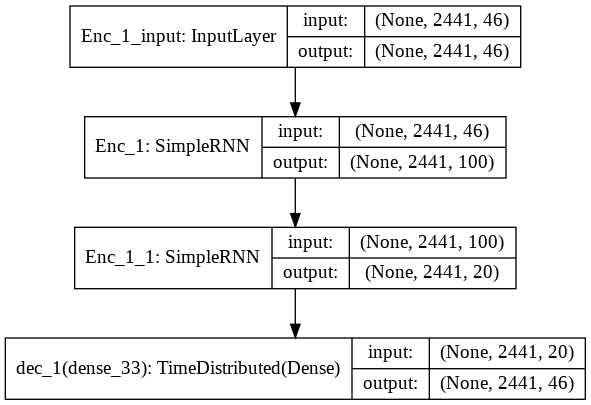

In [103]:
plot_model(model,show_shapes=True,show_layer_names=True)

[31 13 22 33  2 44 25 17 21 32 18 35 45  7  1 46 15 43  5  8 14 42 10 26
 24 29 34 38 36 39  3 40 27 23  4 19 20 28 37 41  6 11 16 30 12  9]


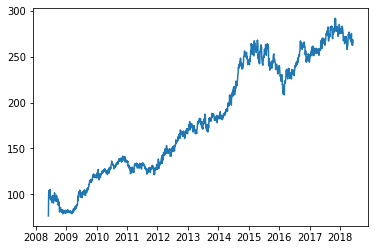

In [104]:
import numpy as np

d_1=np.reshape(Data,(Data.shape[1],Data.shape[2]))
d_2=np.reshape(decoded_data,(Data.shape[1],Data.shape[2]))
d_1=scaler.inverse_transform(d_1)
d_2=scaler.inverse_transform(d_2)
rep_data=d_1-d_2
sim=np.linalg.norm(rep_data,axis=0)
ind=np.argsort(sim)+1
print(str(ind))
plt.plot(df.index,d_2[:,1])


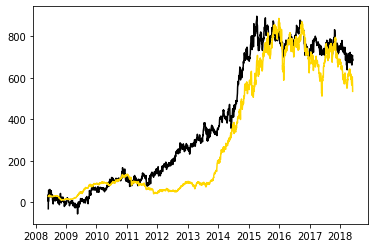

In [108]:
#CHECKPOINT: De-noised(Black) vs Original(Silver)
plt.plot(df.index,d_2[:,ind[30]],'black',df.index,d_1[:,ind[30]],'gold')

In [0]:
Y=df["Price_51"]
Y=np.asarray(Y)

X=df[df.columns[ind[:20]]]
X=scaler.fit_transform(X)

Y=Y.reshape((Y.shape[0],1))
Y=scaler.fit_transform(Y)

In [165]:
from sklearn.model_selection import train_test_split

import numpy as np

X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.30,shuffle=False)
[X_train.shape,X_test.shape,y_train.shape,y_test.shape]

[(1708, 20), (733, 20), (1708, 1), (733, 1)]

https://roamanalytics.com/2016/11/28/shape-matching-with-time-series-data/


The following portion uses the LSTM based architecture to predict the performance of the tracker

In [166]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, RepeatVector,CuDNNLSTM, SimpleRNN, GRU
from keras.utils import plot_model
from keras.losses import KLDivergence
import keras
import datetime
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import regularizers

X_train = np.reshape(X_train, (X_train.shape[0], X.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X.shape[1], 1))

model=Sequential()
model.add(SimpleRNN(100,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]),kernel_regularizer=regularizers.l1(1e-4)))
#model.add(TimeDistributed(Dropout(0.2)))
#model.add(SimpleRNN(50,activation='relu',input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=regularizers.l1(1e-4)))
model.add(Dense(1))

#opt = keras.optimizers.Adam(learning_rate=0.001,decay=1e-5)
opt = keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(loss="mse",optimizer=opt)

history=model.fit(X_train, y_train, epochs=50
                  , batch_size=10, validation_data=(X_test,y_test),callbacks=[EarlyStopping(monitor='val_loss',patience=10,min_delta=0.0001,restore_best_weights=True)])
#model.summary()

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(y_test)



Train on 1708 samples, validate on 733 samples
Epoch 1/50
1708/1708 [==============================] - 1s 531us/step - loss: 0.0265 - val_loss: 0.0037
Epoch 2/50
1708/1708 [==============================] - 1s 448us/step - loss: 0.0015 - val_loss: 0.0041
Epoch 3/50
1708/1708 [==============================] - 1s 433us/step - loss: 0.0013 - val_loss: 0.0033
Epoch 4/50
1708/1708 [==============================] - 1s 427us/step - loss: 0.0012 - val_loss: 0.0033
Epoch 5/50
1708/1708 [==============================] - 1s 428us/step - loss: 0.0011 - val_loss: 0.0024
Epoch 6/50
1708/1708 [==============================] - 1s 432us/step - loss: 0.0011 - val_loss: 0.0042
Epoch 7/50
1708/1708 [==============================] - 1s 429us/step - loss: 0.0010 - val_loss: 0.0023
Epoch 8/50
1708/1708 [==============================] - 1s 420us/step - loss: 9.9439e-04 - val_loss: 0.0035
Epoch 9/50
1708/1708 [==============================] - 1s 429us/step - loss: 9.7554e-04 - val_loss: 0.0026
Epoch 10/

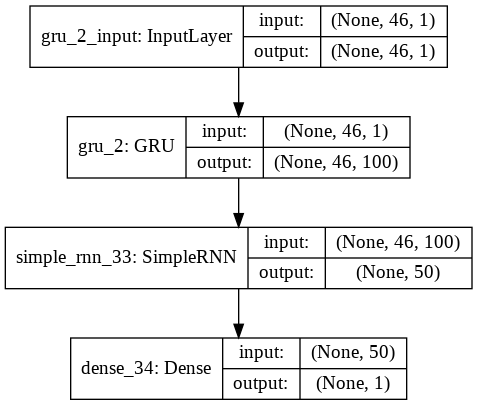

In [112]:
plot_model(model,show_shapes=True)


Now that the model has been built, we verify it's efficacy in the validation set by ploting both the benchmark as well as the tracker values

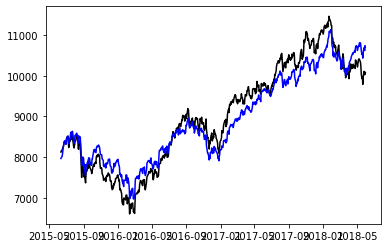

In [167]:
##tracker(black) vs benchmark(blue) in the testing phase
plt.plot(df.index[-Y_test.shape[0]:],test_predict,'black',df.index[-Y_test.shape[0]:],Y_test,'b-')

Testing starts on :2015-06-11 00:00:00


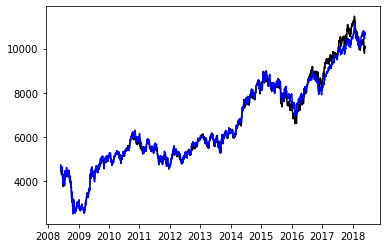

In [168]:
#tracker(black) vs benchmark(blue) over the entire timeline
predicted=np.concatenate((train_predict,test_predict))
plt.plot(df.index, predicted, 'black', df.index, df["Price_51"], 'blue')
test_start_date=df.index[-y_test.shape[0]]

print("Testing starts on :"+str(test_start_date))

Now that I have obtained my predicted time series, I intend to use one of the similarity measures proposed by Mori et al. with their respctive implementation in the **TSDist** library in R.   

In [161]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

base=importr('base')
stats=importr('stats')
ro.r('install.packages("TSdist")')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘fastmap’, ‘miniUI’, ‘webshot’, ‘splus2R’, ‘ifultools’, ‘shiny’, ‘manipulateWidget’, ‘wmtsa’, ‘clv’, ‘rgl’, ‘misc3d’, ‘proxy’, ‘zoo’, ‘xts’, ‘dtw’, ‘TSclust’, ‘locpol’, ‘pdc’, ‘longitudinalData’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/httpuv_1.5.3.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1803128 bytes (1.7 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to consol

<rpy2.rinterface.NULLType object at 0x7f99682aa148> [RTYPES.NILSXP]

In [0]:
TSDist=importr('TSdist')

In [169]:
predicted=np.reshape(predicted,(predicted.shape[0],))
p=pd.Series(predicted,copy=True)
tracker=base.as_numeric(predicted.tolist())
benchmark=base.as_numeric(df["Price_51"].tolist())
dist=TSDist.CCorDistance(tracker, benchmark)
dist

0.005168
